In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('../notebooks/style.mpl')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Respiratory heterotrophy model

In [3]:
eps = 1e-10
tau = 1e0
S2 = 2.

In [4]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = 0.0
    x[x>1e8] = 1e8
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP
    
    nu_cat = (NAD ** S2)/(1 + NAD ** S2) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2)/(1 + NADH ** 2) * phi_resp * gamma_resp_inv * tau
    nu_ana = (NADH ** S6)/(1 + NADH ** S6) * (ATP ** S5)/(1 + ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    mu = nu_ana.copy()
    
    # dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dCorg = 0.0
    dNADH = S2 * nu_cat - 2 * nu_resp - S6 * nu_ana - mu * NADH
    # dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = (S3 * nu_cat + S4 * nu_resp - S5 * nu_ana - mu * ATP)
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

# Regimes of $\frac{d \lambda}{d S_6}$

## Case II: dynamic NADH and ATP levels

For the full model, we have the following expression for how $\lambda$ changes with $S_6$.

$$   \frac{d\lambda}{d S_6} = \frac{(S_2 S_3 + S_1 S_4)}{\left(S_1 \left(ATP +S_5\right) - S_3
   \left(NADH + S_6\right)\right){}^2} \cdot \left[ \frac{\partial J_{resp}}{\partial S_6} \left(S_1 \left(ATP + S_5\right) - S_3 \left(NADH +S_6\right)\right) - J_{resp} \left(S_1 \frac{\partial (ATP)}{\partial S_6} - S_3 \frac{\partial (NADH)}{\partial S_6}\right)
  \right]$$

Since we are interested in the sign of $\frac{d \lambda}{d S_6}$, and the term outside the square brackets is always positive, we have:

$$   \text{sign}\left[\frac{d\lambda}{d S_6}\right] =  \text{sign}\left[ \frac{\partial J_{resp}}{\partial S_6} \left(S_1 \left(ATP + S_5\right) - S_3 \left(NADH +S_6\right)\right) - J_{resp} \left(S_1 \frac{\partial (ATP)}{\partial S_6} - S_3 \frac{\partial (NADH)}{\partial S_6}\right)
  \right]$$

We can now study different regimes of our simulations to understand the sign of $\frac{d \lambda}{d S_6}$. In case I, we considered the regime where NADH levels were homeostatically maintained, i.e., $ \frac{\partial (NADH)}{\partial S_6} = 0 $. We shall now examine a more general case, where NADH levels are dynamic. Fluxes that depend on NADH levels can be either in the linear or saturated regimes, as determined by the following generalized Michaelis-Menten dependence:

$$ \frac{(NADH)^{S_{\alpha i}}}{1 + (NADH)^{S_{\alpha i}}} $$

where $NADH$ is the dimensionless concentration of MADH, measured in units of its half-saturation constant $K_{M, NADH}$. Depending on the value of $S_{\alpha i}$, this expression saturates at different values of $NADH = \frac{[NADH]}{K_{M,NADH}}$, where [NADH] represents the true concentration of NADH in mM units.

For reference, when $S_{\alpha i} = 1$, it saturates (reaches 90% of its maximum value)  at roughly $NADH \approx 10$, and when $S_{\alpha i} = 2$, it reaches the same value at roughly $NADH \approx 3$.

Since we are interested in NADH levels in this regime, it is useful to look at the NADH stoichiometries in the three processes:

$$ J_{cat} \implies S_{cat, NADH} = 2 $$
$$ J_{resp} \implies S_{resp, NADH} = 2 $$
$$ J_{ana} \implies S_{ana, NADH} = S_6 \in [-0.1, 0.5] $$

This suggests that usually, we expect $J_{cat}$ and $J_{resp}$ to be saturated, and independent of NADH levels, while we expect $J_{ana}$ to scale roughly linearly with NADH levels. Thus:

$$J_{cat} \sim \text{independent of NADH}$$
$$J_{resp} \sim \text{independent of NADH}$$
$$J_{ana} \sim NADH^{S_6}$$

Note that bears some similarity to the the case of homeostatic NADH levels, considered previously. That is, in the former case, we assumed that NADH levels did not change, and thus $J_{cat}$ and $J_{resp}$ did not change because of NADH. Here, $J_{cat}$ and $J_{resp}$ would typically respond weakly to changes in NADH levels once $NADH > 3$. 

Thus, going back to the expression for the sign of $\frac{d\lambda}{dS_6}$, we note the key change compared to the former case of homeostatic NADH levels is the possibility of a nonzero $\frac{\partial (NADH)}{\partial S_6}$. We thus care about the sign of this quantity. In particular, for regimes where $\frac{d\lambda}{dS_6} > 0$, we are interested in the sign of $\frac{\partial (NADH)}{\partial S_6}$. In particular, there are two ways for $\frac{d\lambda}{dS_6} > 0$.

### IIa: increase in steady state NADH levels with increasing $S_6$

First, the simplest way is for $\frac{\partial (NADH)}{\partial S_6} > 0$. To see this, note our original expression:

$$   \text{sign}\left[\frac{d\lambda}{d S_6}\right] =  \text{sign}\left[ \frac{\partial J_{resp}}{\partial S_6} \left(S_1 \left(ATP + S_5\right) - S_3 \left(NADH +S_6\right)\right) - J_{resp} \left(S_1 \frac{\partial (ATP)}{\partial S_6} - S_3 \frac{\partial (NADH)}{\partial S_6}\right)
  \right]$$

Assuming that we are typically in the saturated regime for $J_{resp}$ (shown below), we have $J_{resp} = \phi_{resp} \gamma_{resp}^{-1}$, and thus:

$$ \frac{\partial J_{resp}}{\partial S_6} = \frac{\partial \phi_{resp}}{\partial S_6} \gamma^{-1}_{resp} $$

As before, in our simulations, we observe (i) small changes in the optimal $\phi_{resp}$ with increasing $S_6$ compared with changes in the steady state ATP concentration ATP $\ast$, and (ii) thus, the first term in the expression for $\text{sign}\left[\frac{d\lambda}{d S_6}\right]$ is much smaller than the second. Using these, we see that:

$$   \text{sign}\left[\frac{d\lambda}{d S_6}\right] \approx  \text{sign}\left[ - J_{resp} \left( S_1\frac{\partial (ATP)}{\partial S_6} - S_3 \frac{\partial (NADH)}{\partial S_6}\right)
  \right]$$

Thus, similar to case I, one way to increasing $\lambda$ with $S_6$ is if the steady state ATP levels ATP $\ast$ decrease with $S_6$, while the steady state NADH levels NADH $\ast$ increase with $S_6$, i.e.:

$$ \frac{\partial (ATP)^\ast}{\partial S_6} < 0 \hskip 5pt \text{and} \hskip 5pt \frac{\partial (NADH)}{\partial S_6} > 0 \implies \frac{d\lambda}{d S_6} > 0 $$

While simple, this is not the case we typically observe in simulations. Instead, we interestingly observe that the simulations with dynamic NADH and ATP levels and instead in a more interesting second regime, described below.

### IIb: weak decrease in steady state NADH levels with increasing $S_6$

Another way for $\frac{d\lambda}{d S_6} > 0$ would be if NADH levels decreased with $S_6$, but weakly. To see this, note that typical values of the NADH yield of catabolism $S_1 = 2$, while those for the ATP yield of catabolism $S_3 \approx 0.5$. Interestingly, the expression for the dependence of $\lambda$ with $S_6$ weighs the change in ATP with the catabolic NADH yield, and the change in NADH levels with the catabolic ATP yield. Thus for $\frac{d\lambda}{d S_6} > 0$, we need:

$$\frac{\frac{\partial (NADH)}{\partial S_6}}{\frac{\partial (ATP)}{\partial S_6}} < \frac{S_1}{S_3}$$

Since $S_1/S_3 \approx 4$, as long as the slope of NADH is no steeper than 4 times the slope of ATP levels with $S_6$, we expect $\lambda$ to increase with $S_6$. Equivalenty, for the same change in $S_6$, we need steady state NADH levels to increase less than $S_1/S_3 \approx 4$ times compared with ATP levels.

Below, using simuations, we show that our simulations are consistent with this regime, showing why we expect an increasing $\lambda$ with $S_6$ to be robust to fully dynamic NADH and ATP levels. 

Thus, our model suggests that we expect the region where growth rate increases with anabolic NADH usage (more reduced biomass) to be quite broad. This helps explain the growth rate trends observed in the proteome data for organisms engaging in respiratory heterotrophy.

# Simulations

### Parameters

In [5]:
# gamma inverses are in /hr units.
gamma_cat_inv = 1000/3600
gamma_resp_inv = 1000/3600
gamma_ana_inv = 1000/3600

phi_cat = 0.5
phi_ana = 0.4
phi_resp = 0.1

# Default params: reliance on respiration.
S4 = 10.0    # ATP yield of respiration
S3 = 0.5    # ATP yield of catabolism ... NOTE: default should be 0.5
S5 = 1.1    # ATP cost of anabolism
S6 = 0.2    # reduction coefficient of biomass

### Initial conditions

In [6]:
# concentrations in KM units
Corg0 = 1e1
NADH0 = 1e1
O20 = 1e1
ATP0 = 1e0

# KM is in uM
KM = 100
r1 = 10.
r2 = 0.1

### Dynamics

In [7]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 6, 1000 )
S6 = 0.1

In [8]:
def give_nus( y_sol, tpt ):
    x = y_sol[:, tpt].copy()
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]

    NAD = r1 * NADH
    ADP = r2 * ATP

    nu_cat = (NAD ** 2) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2) * phi_resp * gamma_resp_inv * tau
    nu_ana = (NADH ** S6) * (ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    return np.array([nu_cat, nu_resp, nu_ana])

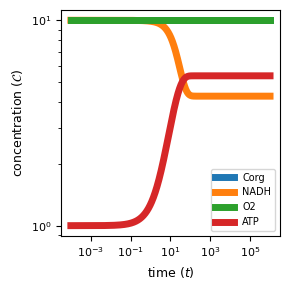

In [9]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=5 )
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

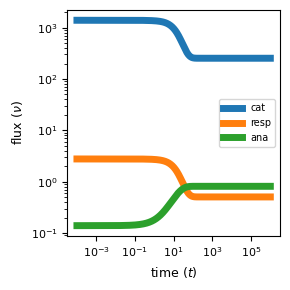

In [10]:
nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'flux (' + r'$\nu$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(3):
    ax.plot( t[:len(nus[idx])], nus[idx], lw=5 )
ax.legend([ 'cat', 'resp', 'ana' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

## Sweeping over $S_6$

In [11]:
atps = []
nadhs = []
mus = []
s6s = []

for S6 in np.linspace(-0.1, 0.5, 100):
    y0 = np.array([Corg0, NADH0, O20, ATP0])
    NUM_METS = len(y0)

    # Evaluation time
    TFINAL = 1e6
    t = np.logspace(-4, 6, 1000)

    y_sol = solve_ivp(het_model, [1e-4, TFINAL], y0, t_eval=t, method='Radau').y

    nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

    atps.append(y_sol[-1, -1])
    nadhs.append(y_sol[1, -1])
    mus.append(nus[-1, -1])
    s6s.append(S6)
    
df = pd.DataFrame({'atps': atps, 'nadhs': nadhs, 's6s': s6s})

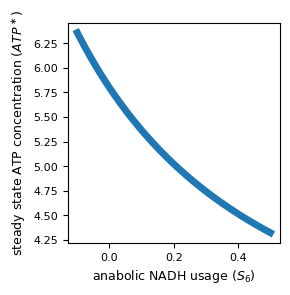

In [12]:
fig, ax = plt.subplots( 1, 1, figsize=(3, 3) )

ax.set_ylabel( 'steady state ATP concentration (' + r'$ATP^\ast$)')
ax.set_xlabel( 'anabolic NADH usage (' + r'$S_6$)')
ax.plot( df['s6s'], df['atps'], lw=5 )

fig.tight_layout()
plt.show()

Measuring $\frac{\partial (ATP)}{\partial S_6}$

In [13]:
(df['atps'].iloc[0] - df['atps'].iloc[-1])/(df['s6s'].iloc[0] - df['s6s'].iloc[-1])

-3.3936174218837163

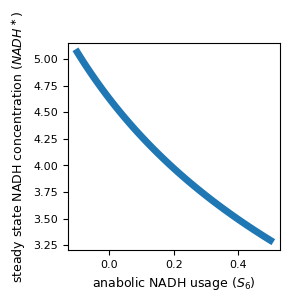

In [14]:
fig, ax = plt.subplots( 1, 1, figsize=(3, 3) )

ax.set_ylabel( 'steady state NADH concentration (' + r'$NADH^\ast$)')
ax.set_xlabel( 'anabolic NADH usage (' + r'$S_6$)')
ax.plot( df['s6s'], df['nadhs'], lw=5 )

fig.tight_layout()
plt.show()

Measuring $\frac{\partial (NADH)}{\partial S_6}$

In [15]:
(df['nadhs'].iloc[0] - df['nadhs'].iloc[-1])/(df['s6s'].iloc[0] - df['s6s'].iloc[-1])

-2.9487084869357503

Measuring $\frac{\frac{\partial (NADH)}{\partial S_6}}{\frac{\partial (ATP)}{\partial S_6}}$

In [16]:
(df['nadhs'].iloc[0] - df['nadhs'].iloc[-1])/(df['atps'].iloc[0] - df['atps'].iloc[-1])

0.8688983230463829

Checking if $\frac{\frac{\partial (NADH)}{\partial S_6}}{\frac{\partial (ATP)}{\partial S_6}} < \frac{S_1}{S_3}$

In [17]:
(df['nadhs'].iloc[0] - df['nadhs'].iloc[-1])/(df['atps'].iloc[0] - df['atps'].iloc[-1]) < 2/S3

True

## Robustness to optimizing $\phi$'s

Above, we assumed that the optimal allocation fractions $\phi_\alpha$ were relatively insensitive to changes in $S_6$. 

Below, we show that even when optimizing the $\phi$'s, we are still in the regime where $\frac{\frac{\partial (NADH)}{\partial S_6}}{\frac{\partial (ATP)}{\partial S_6}} < \frac{S_1}{S_3}$.

In [18]:
opt_atps = []
opt_nadhs = []
opt_phi_resps = []
s6s = []

for S6 in np.linspace(0.0, 0.5, 100):
    # optimizing 
    cats_to_sample = np.linspace(0.1, 0.5, 10)
    resps_to_sample = np.linspace(0.01, 0.2, 10)

    allatps, allnadhs, allmus, allphis = [], [], [], []
    for phi_cat in cats_to_sample:
        for phi_resp in resps_to_sample:
            phi_ana = 1-phi_cat-phi_resp

            y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
            NUM_METS = len(y0)

            # Evaluation time
            TFINAL = 1e6
            t = np.logspace(-4, 6, 1000 )

            y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

            nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T
            
            allatps.append(y_sol[-1, -1])
            allnadhs.append(y_sol[1, -1])
            allmus.append(nus[-1, -1])
            allphis.append([phi_cat, phi_resp, phi_ana])

    mus = np.array(allmus)
    max_index = np.argmax(mus)  # finding growth-optimal index
    phi_cat, phi_resp, phi_ana = allphis[max_index] # optimal phis

    # storing optimized ATP*, NADH* and optimal phi_resp.
    opt_atps.append(allatps[max_index])
    opt_nadhs.append(allnadhs[max_index])
    opt_phi_resps.append(phi_resp)
    s6s.append(S6)

df = pd.DataFrame({'atps': opt_atps, 'nadhs': opt_nadhs, 's6s': s6s, 'optphiresps': opt_phi_resps})

In [19]:
phi_cat, phi_resp, phi_ana

(0.5, 0.2, 0.3)

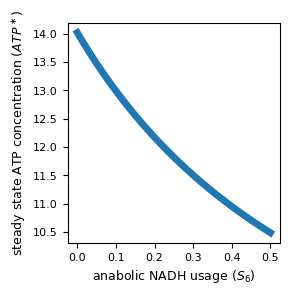

In [20]:
fig, ax = plt.subplots( 1, 1, figsize=(3, 3) )

ax.set_ylabel( 'steady state ATP concentration (' + r'$ATP^\ast$)')
ax.set_xlabel( 'anabolic NADH usage (' + r'$S_6$)')
ax.plot( df['s6s'], df['atps'], lw=5 )

fig.tight_layout()
plt.show()

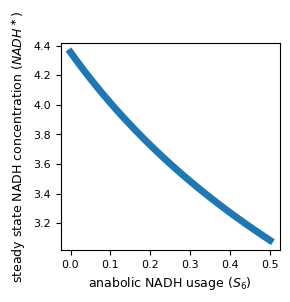

In [21]:
fig, ax = plt.subplots( 1, 1, figsize=(3, 3) )

ax.set_ylabel( 'steady state NADH concentration (' + r'$NADH^\ast$)')
ax.set_xlabel( 'anabolic NADH usage (' + r'$S_6$)')
ax.plot( df['s6s'], df['nadhs'], lw=5 )

fig.tight_layout()
plt.show()

Measuring $\frac{\partial (ATP)}{\partial S_6}$

In [22]:
(df['atps'].iloc[0] - df['atps'].iloc[-1])/(df['s6s'].iloc[0] - df['s6s'].iloc[-1])

-7.061313464417189

Measuring $\frac{\partial (NADH)}{\partial S_6}$

In [23]:
(df['nadhs'].iloc[0] - df['nadhs'].iloc[-1])/(df['s6s'].iloc[0] - df['s6s'].iloc[-1])

-2.5449588604602376

Measuring $\frac{\frac{\partial (NADH)}{\partial S_6}}{\frac{\partial (ATP)}{\partial S_6}}$

In [24]:
(df['nadhs'].iloc[0] - df['nadhs'].iloc[-1])/(df['atps'].iloc[0] - df['atps'].iloc[-1])

0.3604087077120414

Checking if $\frac{\frac{\partial (NADH)}{\partial S_6}}{\frac{\partial (ATP)}{\partial S_6}} < \frac{S_1}{S_3}$

In [25]:
(df['nadhs'].iloc[0] - df['nadhs'].iloc[-1])/(df['atps'].iloc[0] - df['atps'].iloc[-1]) < 2/S3

True